In [1]:
import os 
from typing import Literal

# анализ таблиц
import pandas as pd
import numpy as np
from datetime import datetime as dt
# анализ пропущенных значений 
import missingno as msno
# визуализация
import matplotlib.pyplot as plt
import seaborn as sns

try:
    import importlib
    importlib.reload(prep)
except NameError: 
    import autolabeling_time_series_data.data.data_analysis as prep

### Функции для анализа

In [2]:
def do_nan_analysis(data:pd.DataFrame, thresh_type:str='thresh_pct', use_msno:bool=False, thresh_pct:np.float64=0.5) -> prep.nan_analysis:
    nan_analysis = prep.nan_analysis(data)
    nan_analysis.get_nan_stats_dict()

    nan_analysis.show_nan_distr()
    nan_analysis.show_nan_distr(thresh_type=thresh_type)
        
    
    if use_msno == True:
        nan_analysis.msno_bar(thresh_pct=thresh_pct)
        nan_analysis.msno_matrix(thresh_pct=thresh_pct)
        nan_analysis.msno_heatmap(thresh_pct=thresh_pct)
    else:
        nan_analysis.msno_bar(data)

    return nan_analysis

### Датасет Hard Drive Test Data

**Ссылка**: https://www.kaggle.com/datasets/backblaze/hard-drive-test-data

**Описание с kaggle**: Каждый день Backblaze делает снимок каждого работающего жесткого диска, который включает в себя основную информацию о жестком диске (например, емкость, неисправность) и статистику S.M.A.R.T. по каждому диску. Этот набор данных содержит данные за первые два квартала 2016 года. Этот набор данных содержит базовую информацию о жестком диске и 90 столбцов или необработанных и нормализованных значений 45 различных статистических данных S.M.A.R.T. 

Каждая строка представляет собой ежедневный снимок одного жесткого диска:
* date: Date in yyyy-mm-dd format
* serial_number: Manufacturer-assigned serial number of the drive
* model: Manufacturer-assigned model number of the drive
* capacity_bytes: Drive capacity in bytes
* failure: Contains a “0” if the drive is OK. Contains a “1” if this is the last day the drive was operational before failing.
* 90 variables that begin with 'smart': Raw and Normalized values for 45 different SMART stats as reported by the given drive

Некоторые моменты, которые следует учитывать при обработке данных:
* Значение статистики S.M.A.R.T. может различаться в зависимости от производителя и модели. Возможно, более информативным будет сравнение накопителей, схожих по модели и производителю
* Некоторые столбцы S.M.A.R.T. могут содержать значения за пределами допустимых значений
* При сбое диска столбцу "сбой" в день сбоя присваивается значение 1, и, начиная со следующего дня, диск будет удален из набора данных. Кроме того, каждый день добавляются новые диски. Это означает, что общее количество дисков в день может меняться.
* S.M.A.R.T. 9 - это количество часов, в течение которых диск использовался. Чтобы рассчитать срок службы диска в днях, разделите это число на 24.

**Выводы**:
1. Было замечено ряд особенностей в составе данных ВР: 
* В частности наблюдение первого дня 01.01.2016 дублируется для всех серийных номеров. 
* Также пропущены значения за период февраль-март 2016. Это делит текущую выборку на две части: до 22.01.2016 и с 01.04.2016 по 30.04.2016 (см. рис.1). Почти все серийные номера (> 600 тыс.) не сломались и по ним есть данные, при этом только 15 ломаются в последнюю дату (см. рис.3). 
* (?) Не понятно почему есть наблюдения, по которым данные обрываются без выставления таргета равного 1 (см. рис.2)

![рис. 1](./pics/backblaze_days_dist_hist.png) 
![рис. 2](./pics/backblaze_live_not_all_period.png)
![рис. 3](./pics/backblaze_failure_1.png) 

**Результат анализа:** 

Итоговая выборка будет содержать данные как на рис.2, где диски, которые работали на всем периоде, будут проигнорированы за исключением 1000 наблюдений. Код для создания выборки следующий:


```import pandas as pd
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
raw_data = pd.read_csv('data/kagglehub/datasets/backblaze/hard-drive-test-data/versions/1/harddrive.csv')
target_and_date_df = raw_data.loc[:, ['serial_number','failure']].drop_duplicates(keep='last').reset_index()
target_and_date_df['target_last_date'] = target_and_date_df['index'].apply(lambda i: raw_data.loc[i, 'date'])
target_and_date_df_1 = target_and_date_df[target_and_date_df.target_last_date != '2016-01-01']
target_and_date_df_1.loc[:,'days_num'] = target_and_date_df_1.loc[:,'target_last_date'].apply(lambda x: (pd.to_datetime(x) - pd.Timestamp('2016-01-01')).days )
sn_before_118 = target_and_date_df_1.loc[(target_and_date_df_1.days_num <= 118)|(target_and_date_df_1.failure==1), 'serial_number'].to_list()
sn_add_after_118 = target_and_date_df_1.loc[(target_and_date_df_1.days_num > 118)|(target_and_date_df_1.failure!=1), 'serial_number'].sample(n=1000, random_state=21).to_list()
sample_sn1 = sn_before_118+sn_add_after_118
sample1_sn = raw_data.loc[raw_data.serial_number.isin(sample_sn1)]
fetures_nan_median = sample1_sn.notna().sum().median()
nan_df = sample1_sn.notna().sum()
nan_df = nan_df[nan_df > fetures_nan_median]
sample1_sn.loc[:,nan_df.index.to_list()].to_excel('data/kagglehub/datasets/backblaze/hard-drive-test-data/dataset.xlsx')
```


In [3]:
# Hard Drive Test Data 
raw_data = pd.read_csv('kagglehub/datasets/backblaze/hard-drive-test-data/versions/1/harddrive.csv', parse_dates=['date'])
raw_data.head()

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
0,2016-01-01,MJ0351YNG9Z0XA,Hitachi HDS5C3030ALA630,1.482490e-311,0,100,0,135.0,108.0,143,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-01-01,Z305B2QN,ST4000DM000,1.976651e-311,0,113,54551400,NaN,NaN,96,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-01-01,MJ0351YNG9Z7LA,Hitachi HDS5C3030ALA630,1.482490e-311,0,100,0,136.0,104.0,124,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-01-01,MJ0351YNGABYAA,Hitachi HDS5C3030ALA630,1.482490e-311,0,100,0,136.0,104.0,137,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-01-01,WD-WMC4N2899475,WDC WD30EFRX,1.482490e-311,0,200,0,NaN,NaN,175,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


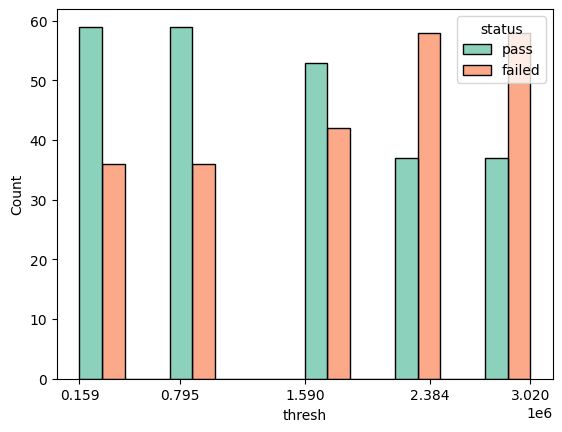

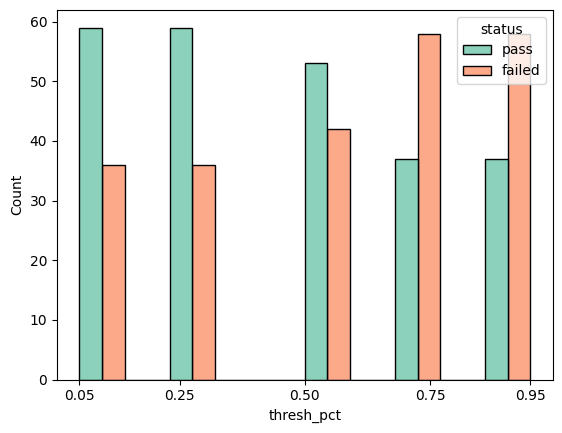

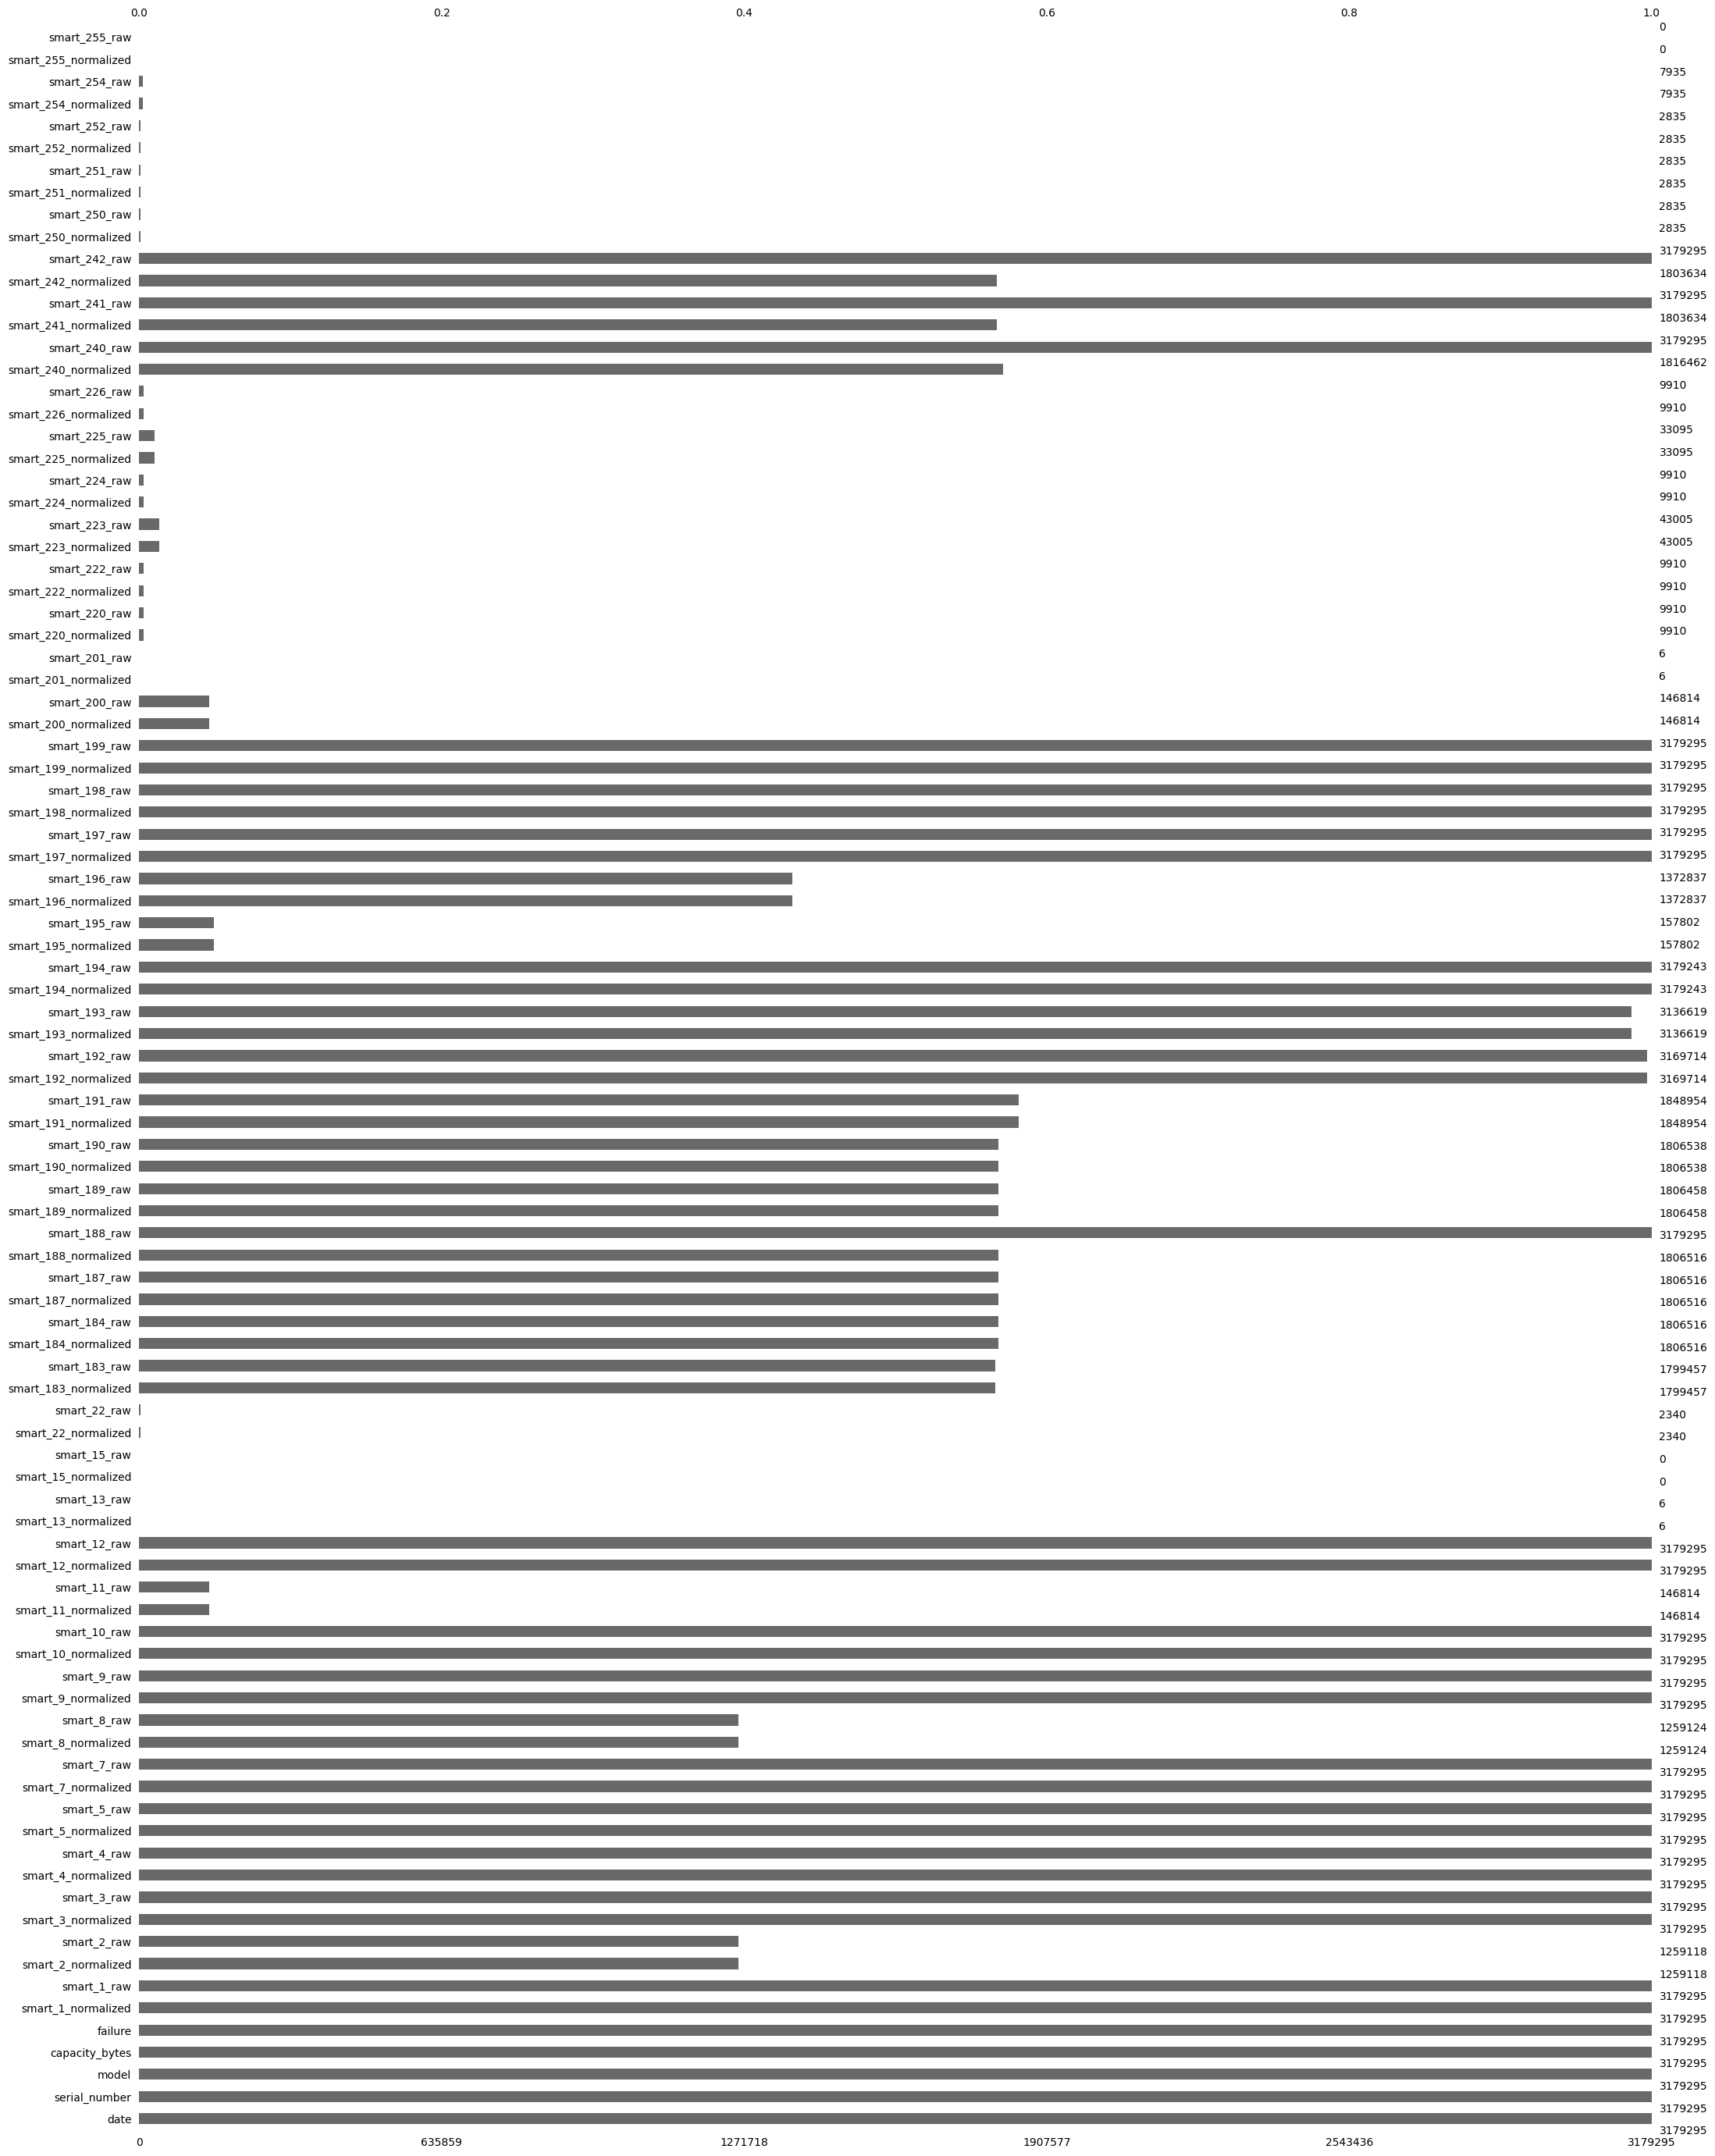

'\nВизуальный анализ графиков пропусков показывает, что для 39 переменных кол-во пропусков минимально и почти равно 0. Поэтому для дальнейшего анализа будут использованы именно эти переменные. Однако, интересно, что для статистик начиная с 183-191 кол-во пропусков равно 50%. Возможно они относятся только к определенным моделям.  \n'

In [4]:
drive_nan_analysis = do_nan_analysis(raw_data)
"""
Визуальный анализ графиков пропусков показывает, что для 39 переменных кол-во пропусков минимально и почти равно 0. Поэтому для дальнейшего анализа будут использованы именно эти переменные. Однако, интересно, что для статистик начиная с 183-191 кол-во пропусков равно 50%. Возможно они относятся только к определенным моделям.  
"""

In [11]:
# отбираем только колонки, которые проходят тест на 5-25% пропусков  
full_sample_stat = drive_nan_analysis.get_nan_distr()
full_sample_cols = full_sample_stat.loc[full_sample_stat.thresh_pct == 0.95, 'feature'].values
full_sample_cols

array(['date', 'serial_number', 'model', 'capacity_bytes', 'failure',
       'smart_1_normalized', 'smart_1_raw', 'smart_2_normalized',
       'smart_2_raw', 'smart_3_normalized', 'smart_3_raw',
       'smart_4_normalized', 'smart_4_raw', 'smart_5_normalized',
       'smart_5_raw', 'smart_7_normalized', 'smart_7_raw',
       'smart_8_normalized', 'smart_8_raw', 'smart_9_normalized',
       'smart_9_raw', 'smart_10_normalized', 'smart_10_raw',
       'smart_11_normalized', 'smart_11_raw', 'smart_12_normalized',
       'smart_12_raw', 'smart_13_normalized', 'smart_13_raw',
       'smart_15_normalized', 'smart_15_raw', 'smart_22_normalized',
       'smart_22_raw', 'smart_183_normalized', 'smart_183_raw',
       'smart_184_normalized', 'smart_184_raw', 'smart_187_normalized',
       'smart_187_raw', 'smart_188_normalized', 'smart_188_raw',
       'smart_189_normalized', 'smart_189_raw', 'smart_190_normalized',
       'smart_190_raw', 'smart_191_normalized', 'smart_191_raw',
       'smart_1

In [4]:
drive_date_analysis = prep.date_analysis(raw_data)
drive_data_2 = drive_date_analysis.evaluate_intervals()

Date column name is date
minimal date: 2016-01-01 00:00:00
maximum date: 2016-04-29 00:00:00



In [18]:
groupby_cols = ['model','serial_number']
target = 'failure'

tt1 = drive_data_2.groupby(groupby_cols+[target], as_index=False).agg({'days_num':'max'}).sort_values('days_num', ascending=False)

print(tt1.shape)
tt1

(66192, 4)


,model,serial_number,failure,days_num
66188,WDC WD800JB,WD-WMAM9DSH9912,0,119
0,HGST HDS5C4040ALE630,PL1310LAG0EMWA,0,119
1,HGST HDS5C4040ALE630,PL1310LAG0HBJA,0,119
2,HGST HDS5C4040ALE630,PL1311LAG38K1H,0,119
3,HGST HDS5C4040ALE630,PL1321LAG33K1H,0,119
...,...,...,...,...
31921,ST4000DM000,W3006E5B,1,0
45171,ST4000DM000,Z302A14M,0,0
35708,ST4000DM000,Z300KHN0,1,0
43314,ST4000DM000,Z3025LCN,0,0


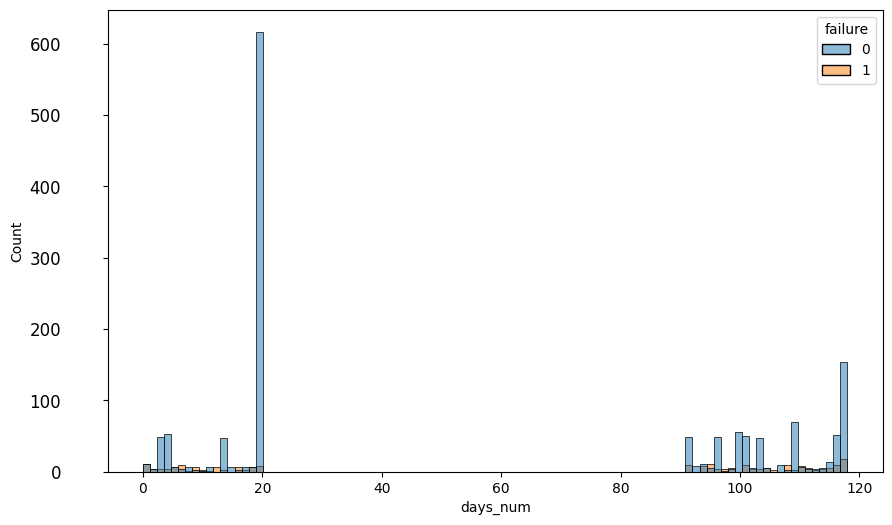

In [19]:
plt.figure(figsize=(10, 6))
sns.histplot(data=tt1.query('days_num < 119'), x='days_num', hue=target, bins=100)

plt.tick_params(axis='y', labelsize=12, pad=30)


In [20]:
groupby_cols = ['model','serial_number', 'date']
target = 'failure'

tt1 = drive_data_2.groupby(groupby_cols+[target], as_index=False).agg({'days_num':'max'}).sort_values('days_num', ascending=False)

print(tt1.shape)
tt1

(3058798, 5)


,model,serial_number,date,failure,days_num
2677521,ST4000DM000,Z305D26A,2016-04-29,0,119
1219586,ST4000DM000,S300X91C,2016-04-29,0,119
1028225,Hitachi HDS722020ALA330,JK11A8B9J2KE2F,2016-04-29,0,119
2968266,WDC WD30EFRX,WD-WCC4N0254819,2016-04-29,0,119
2066440,ST4000DM000,Z3025L8S,2016-04-29,0,119
...,...,...,...,...,...
1603494,ST4000DM000,W300R9JJ,2016-01-01,0,0
1603444,ST4000DM000,W300R9HW,2016-01-01,0,0
330613,HGST HMS5C4040ALE640,PL2331LAGU9K6J,2016-01-01,0,0
2211933,ST4000DM000,Z302DYW4,2016-01-01,0,0


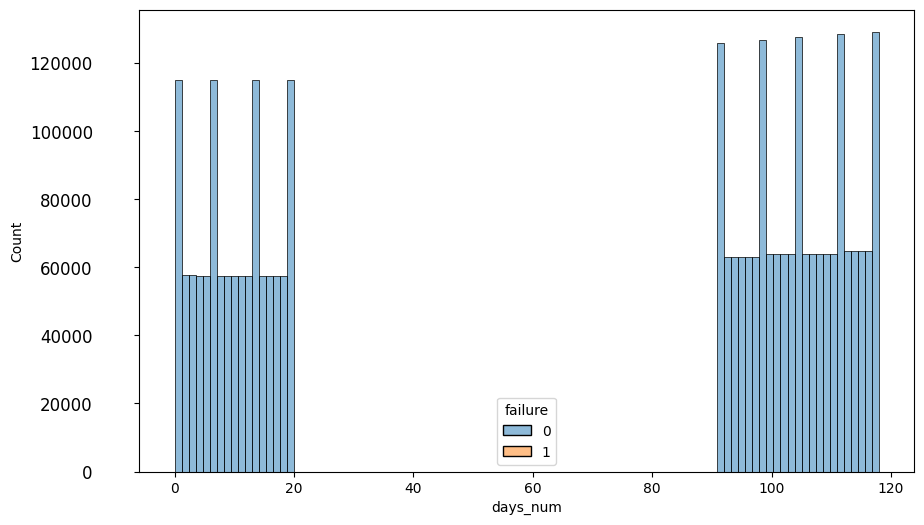

In [45]:
plt.figure(figsize=(10, 6))
axes = sns.histplot(data=tt1.query('days_num < 119'), x='days_num', hue=target, bins=100)

plt.tick_params(axis='y', labelsize=12, pad=30)


In [56]:
drive_data_2.groupby('days_num')['date'].count()

days_num
0      115090
1       57545
2       57606
3       57606
4       57561
5       57515
6       57515
7       57515
8       57515
9       57514
10      57515
11      57515
12      57515
13      57515
14      57561
15      57515
16      57514
17      57500
18      57515
19      57510
20      57469
91     125904
92      62952
93      62952
94      62952
95      62906
96      62906
97      62906
98      62906
99      63872
100     63872
101     63780
102     63780
103     63780
104     63795
105     63795
106     63841
107     63841
108     63841
109     63887
110     63826
111     63825
112     64745
113     64745
114     64746
115     64745
116     64746
117     64699
118     64562
119     64562
Name: date, dtype: int64

<Axes: xlabel='days_num', ylabel='Count'>

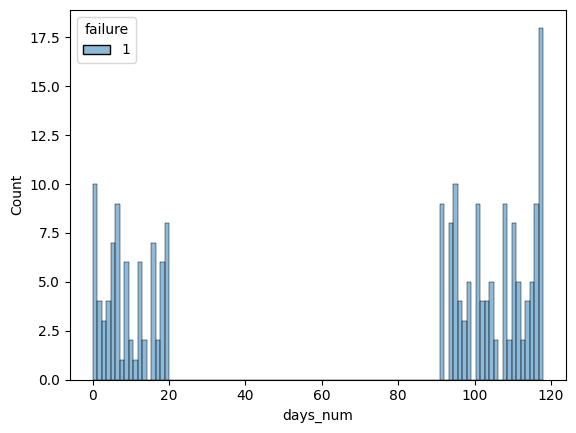

In [9]:
sns.histplot(data=tt1.query(f'days_num < 119 & {target} == 1'), x='days_num', hue = target, bins=100)

In [4]:
# # пример поломки через какое-то время 
# raw_data.loc[raw_data.serial_number=='W0Q6KWV8']

### Italian  Power Suply

**Ссылка**: https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.datasets.load_italy_power_demand.html#sktime.datasets.load_italy_power_demand sktime

**Описание**: В датасете представлены результаты сбора показателей потребления электроэнергии на протяжении 24 ч. для двух периодов (? не помню: июлю-октябрь и другой). Первый период имеет метку 1, второй метку 2. 

![рис. 4](./pics/ItalyPowerSuply_2clusters_examples.png) 

**Выводы**:

**Результат анализа:** 


In [73]:
from sktime.datasets import load_italy_power_demand

# load an example time series panel in pd-multiindex mtype
X, y = load_italy_power_demand(return_type="pd-multiindex", split="train")

# renaming columns for illustrative purposes
X.columns = ["total_power_demand"]
X.index.names = ["day_ID", "hour_of_day"]

In [74]:
X

total_power_demand
day_ID hour_of_day                    
0      0                     -0.710518
       1                     -1.183320
       2                     -1.372442
       3                     -1.593083
       4                     -1.467002
...                                ...
66     19                    -0.268847
       20                     0.232305
       21                     2.424845
       22                     1.923693
       23                     1.171965

[1608 rows x 1 columns]

In [75]:
y

array(['1', '1', '2', '2', '1', '1', '2', '1', '1', '2', '2', '1', '1',
       '2', '1', '2', '1', '1', '2', '1', '1', '2', '1', '1', '1', '1',
       '1', '2', '2', '1', '1', '2', '2', '1', '2', '2', '1', '2', '1',
       '2', '1', '1', '2', '2', '1', '2', '2', '2', '2', '1', '1', '2',
       '2', '2', '1', '2', '2', '1', '1', '2', '2', '1', '1', '2', '1',
       '2', '2'], dtype='<U1')

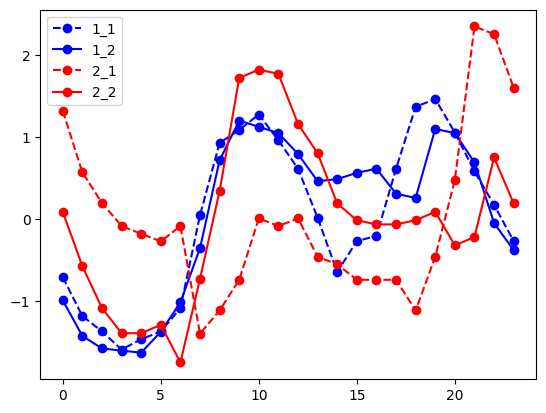

In [76]:
tb1 = X.reset_index(drop=False)
ts1 = tb1[tb1.day_ID==0]
ts2 = tb1[tb1.day_ID==1]
ts3 = tb1[tb1.day_ID==2]
ts4 = tb1[tb1.day_ID==6]

import matplotlib.pyplot as plt

plt.plot(ts1.reset_index()['total_power_demand'], color='blue', marker='o', linestyle='dashed', label = '1_1')
plt.plot(ts2.reset_index()['total_power_demand'], color='blue', marker='o',label='1_2')
plt.plot(ts3.reset_index()['total_power_demand'], color='red', marker='o', linestyle='dashed', label = '2_1')
plt.plot(ts4.reset_index()['total_power_demand'], color='red', marker='o',label='2_2')
plt.legend()
plt.show()

In [84]:
y.shape

(40,)

### Basic Motion

**Ссылка**: https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.datasets.load_basic_motions.html sktime

**Описание**: В датасете представлены результаты сбора показателей движения по 3 осям с мобильных телефонов. Задача мультиклассификации. 

Всего 4 меток классов:
1. walking,
2. resting, 
3. running,  
4. badminton

Оригинальное объяснение:
 
Dimensionality: multivariate, 6 Series length: 100 Train cases: 40 Test cases: 40 Number of classes: 4

The data was generated as part of a student project where four students performed four activities whilst wearing a smart watch. The watch collects 3D accelerometer and a 3D gyroscope It consists of four classes, which are walking, resting, running and badminton. Participants were required to record motion a total of five times, and the data is sampled once every tenth of a second, for a ten second period.

**Выводы**:

**Результат анализа:** 


In [80]:
from sktime.datasets import load_basic_motions

# load an example time series panel in pd-multiindex mtype
X, y = load_basic_motions(return_type="pd-multiindex", split="train")

# renaming columns for illustrative purposes
X.columns = ["accel_1", "accel_2", "accel_3", "gyro_1", "gyro_2", "gyro_3"]
X.index.names = ["trial_no", "timepoint"]

In [81]:
X

accel_1   accel_2   accel_3    gyro_1    gyro_2    gyro_3
trial_no timepoint                                                            
0        0          0.079106  0.394032  0.551444  0.351565  0.023970  0.633883
         1          0.079106  0.394032  0.551444  0.351565  0.023970  0.633883
         2         -0.903497 -3.666397 -0.282844 -0.095881 -0.319605  0.972131
         3          1.116125 -0.656101  0.333118  1.624657 -0.569962  1.209171
         4          1.638200  1.405135  0.393875  1.187864 -0.271664  1.739182
...                      ...       ...       ...       ...       ...       ...
39       95         1.239144 -6.142442  0.028264 -2.309144  1.472845 -0.998765
         96         0.261434  0.205915 -0.224944 -0.524684  0.769715  0.157139
         97         2.490353 -0.878765 -0.597296  0.111862 -0.117188 -0.050604
         98         4.122120  0.911620 -0.465409  0.535338  0.197090  0.442120
         99         3.169270  0.826934 -0.362036 -0.298298  0.250357  0.428803

[4000 rows x 6 columns]

In [83]:
y.shape

(40,)